Introduction


Explain the columns:

Read here: https://www1.ncdc.noaa.gov/pub/data/cdo/documentation/GHCND_documentation.pdf


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from datetime import timedelta


In [2]:
weather_data = pd.read_csv('local_weather.csv')
weather_data.head()


,"STATION,""NAME"",""DATE"",""ACMH"",""ACSH"",""AWND"",""DAPR"",""FMTM"",""FRGT"",""MDPR"",""PGTM"",""PRCP"",""SNOW"",""SNWD"",""TAVG"",""TMAX"",""TMIN"",""TSUN"",""WDF1"",""WDF2"",""WDF5"",""WDFG"",""WSF1"",""WSF2"",""WSF5"",""WSFG"",""WT01"",""WT02"",""WT03"",""WT04"",""WT05"",""WT07"",""WT08"",""WT09"",""WT16"",""WT18"""
0,"USW00023230,""OAKLAND INTERNATIONAL AIRPORT, CA..."
1,"USW00023230,""OAKLAND INTERNATIONAL AIRPORT, CA..."
2,"USW00023230,""OAKLAND INTERNATIONAL AIRPORT, CA..."
3,"USW00023230,""OAKLAND INTERNATIONAL AIRPORT, CA..."
4,"USW00023230,""OAKLAND INTERNATIONAL AIRPORT, CA..."


The read_csv does not properly delimit the csv file (due the the " next to the comma). Lets read file line by line and replace the ".


In [3]:
weather_data = pd.read_csv("local_weather.csv", sep="\,").apply(
    lambda x: x.str.replace(r"\"", ""))
weather_data.columns = weather_data.columns.str.replace(r"\"", "")

weather_data.head()


C:\Users\masv\AppData\Local\Temp\ipykernel_16192\3305524003.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  weather_data = pd.read_csv("local_weather.csv", sep="\,").apply(
C:\Users\masv\AppData\Local\Temp\ipykernel_16192\3305524003.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  lambda x: x.str.replace(r"\"", ""))
C:\Users\masv\AppData\Local\Temp\ipykernel_16192\3305524003.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  weather_data.columns = weather_data.columns.str.replace(r"\"", "")


,STATION,NAME,DATE,ACMH,ACSH,AWND,DAPR,FMTM,FRGT,MDPR,...,WT01,WT02,WT03,WT04,WT05,WT07,WT08,WT09,WT16,WT18
"""USW00023230",OAKLAND INTERNATIONAL AIRPORT,CA US,1960-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,
"""USW00023230",OAKLAND INTERNATIONAL AIRPORT,CA US,1960-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,
"""USW00023230",OAKLAND INTERNATIONAL AIRPORT,CA US,1960-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,
"""USW00023230",OAKLAND INTERNATIONAL AIRPORT,CA US,1960-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,
"""USW00023230",OAKLAND INTERNATIONAL AIRPORT,CA US,1960-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,


Lets see how many nan values there are in the dataset


<Figure size 1000x1000 with 0 Axes>

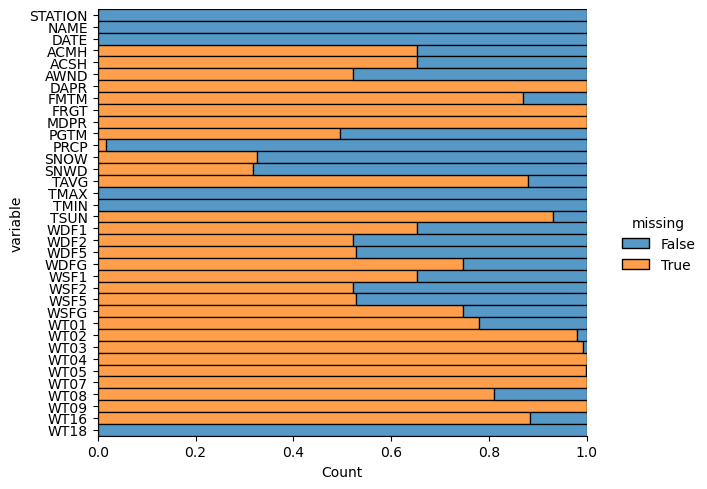

In [4]:
plt.figure(figsize=(10, 10))
sns.displot(data=weather_data.isna().melt(value_name='missing'),
             y='variable', hue='missing', multiple='fill', aspect=1.25)


As we can see, there are numerous columns that have a lot of missing values.

Lets take away many of the unecessary ones, and we will only keep:

PRCP — total precipitation
TMAX — maximum daily temperature
TMIN — minimum daily temperature
SNOW — the total daily snowfall
SNWD — total snow depth on the ground


<AxesSubplot:ylabel='DATE'>

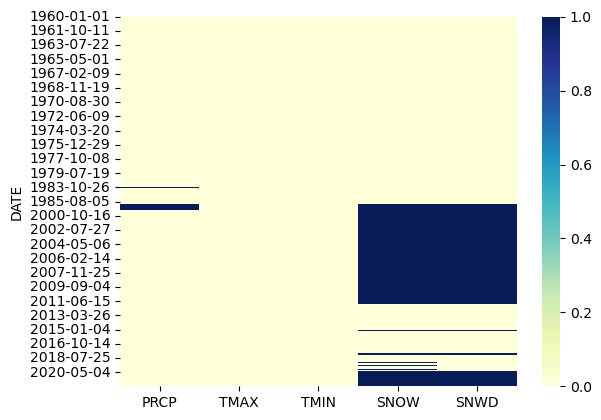

In [5]:
cleaned_weather_data = weather_data[[
    'PRCP', 'TMAX', 'TMIN', 'SNOW', 'SNWD', 'DATE']]
cleaned_weather_data = cleaned_weather_data.set_index('DATE')
sns.heatmap(cleaned_weather_data.isna(),cmap='YlGnBu')


Quite a lot of missing values in SNOW and SNWD, lets see if we can extract any useful information from the columns


In [6]:
cleaned_weather_data[['SNOW', 'SNWD']].value_counts(dropna=False)


SNOW  SNWD
0.0   0.0     11352
NaN   NaN      5328
      0.0       151
0.0   NaN        27
1.0   0.0         1
dtype: int64

almost all values are 0 and many NaN. Lets drop the two columns!


In [7]:
cleaned_weather_data = cleaned_weather_data.drop(['SNOW', 'SNWD'], axis=1)


#### __Data cleaning__

Lets have a look and see if any of the remaining columns have any missing data, and explore the dataset in order to fill in the missing values. But first, lets convert the values to numerical values and index to datetime.


In [8]:
cleaned_weather_data[['PRCP', 'TMIN', 'TMAX']] = cleaned_weather_data[[
    'PRCP', 'TMIN', 'TMAX']].astype(float)
cleaned_weather_data.index = pd.to_datetime(cleaned_weather_data.index)
cleaned_weather_data.isna().sum()


PRCP    281
TMAX      9
TMIN     10
dtype: int64

In order to fill in any missing values, lets explore the data a bit more to properly understand the dataset.


Text(0, 0.5, '[mm]')

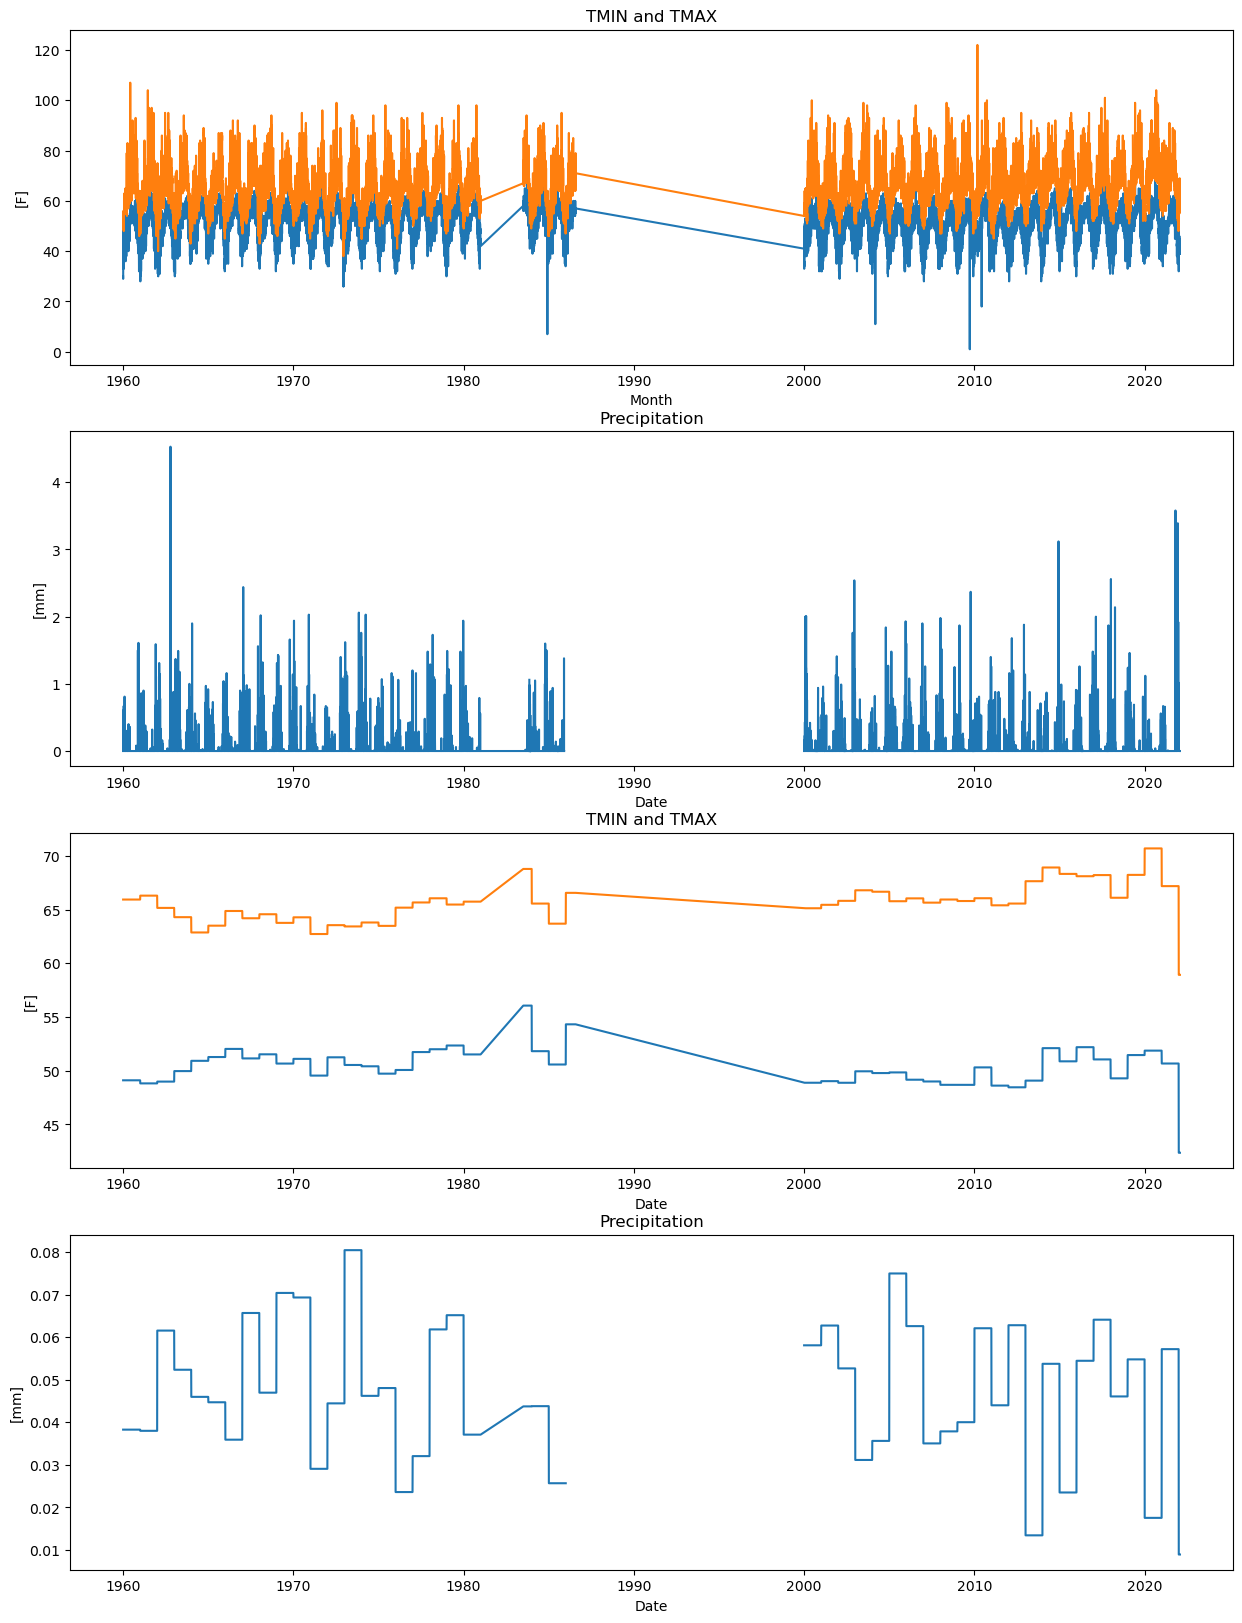

In [9]:
fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(15, 20))

# Only TMIN and TMAX
ax[0].set(title='TMIN and TMAX')
ax[0].plot(cleaned_weather_data[['TMIN', 'TMAX']])
ax[0].set_xlabel('Month')
ax[0].set_ylabel('[F]')

# Only precipitation
ax[1].set(title='Precipitation')
ax[1].plot(cleaned_weather_data['PRCP'])
ax[1].set_xlabel('Date')
ax[1].set_ylabel('[mm]')

# Plot over every year for TMIN and TMAX
ax[2].set(title='TMIN and TMAX')
ax[2].plot(cleaned_weather_data[['TMIN', 'TMAX']].groupby(
    cleaned_weather_data.index.year).transform('mean'))
ax[2].set_xlabel('Date')
ax[2].set_ylabel('[F]')

# Plot for every year for Precipitation
ax[3].set(title='Precipitation')
ax[3].plot(cleaned_weather_data['PRCP'].groupby(
    cleaned_weather_data.index.year).transform('mean'))
ax[3].set_xlabel('Date')
ax[3].set_ylabel('[mm]')


There is quite a bit of yearly variation, especially for precipitation. Additionally, there is a segment in the data that have missing values, since the data is simply a straight line for TMIN and TMAX. Lets first remove those datapoints, and replace with NaN.

Lets explore these two "straight line" segments of the dataset a bit further.


Text(0.5, 0, 'Date')

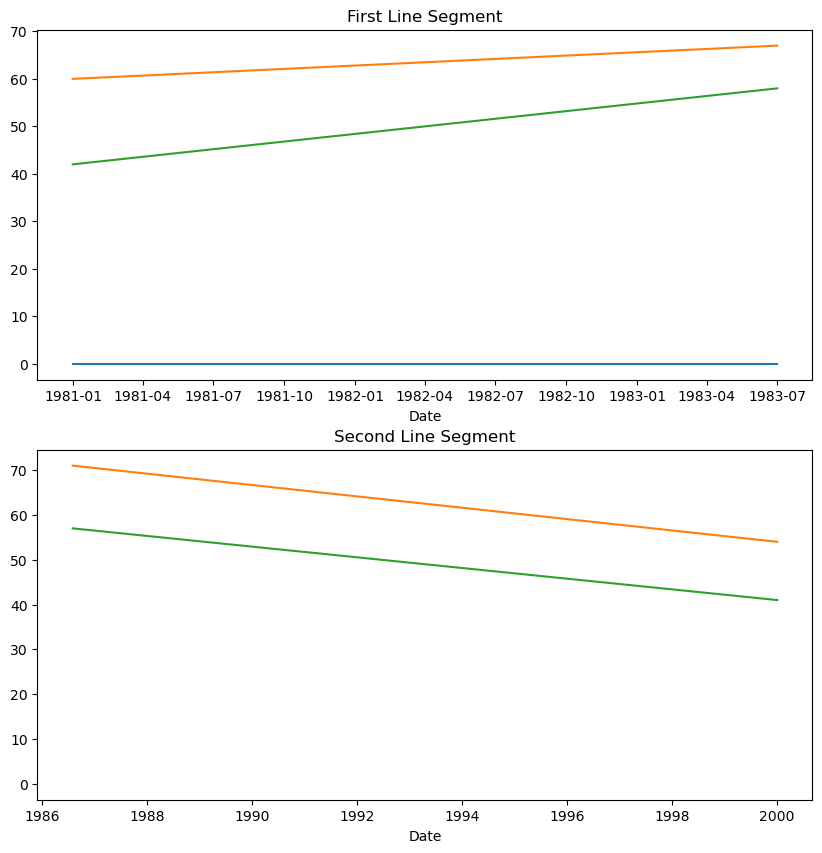

In [10]:
first_line_segment = cleaned_weather_data[(cleaned_weather_data.index > dt.datetime(year=1980, month=12, day=30)) & (
    cleaned_weather_data.index < dt.datetime(year=1983, month=7, day=2))]

second_line_segment = cleaned_weather_data[(cleaned_weather_data.index > dt.datetime(year=1986, month=7, day=30)) & (
    cleaned_weather_data.index < dt.datetime(year=2000, month=1, day=2))]

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))
ax[0].set(title='First Line Segment')
ax[0].plot(first_line_segment)
ax[0].set_xlabel('Date')

ax[1].set(title='Second Line Segment')
ax[1].plot(second_line_segment)
ax[1].set_xlabel('Date')


What is interesting to note here is that years with "line-segments" are not in the dataframe, they just get interpolated by matplotlib. To confirm this, lets try to get values for one different year for each segment. The year 1982 (for the first segment) and 1992 (for the second segment)


In [11]:
cleaned_weather_data[(cleaned_weather_data.index > dt.datetime(year=1982, month=1, day=1)) & (
    cleaned_weather_data.index < dt.datetime(year=1983, month=1, day=1))]


,PRCP,TMAX,TMIN
DATE,,,


In [12]:
cleaned_weather_data[(cleaned_weather_data.index > dt.datetime(year=1992, month=1, day=1)) & (
    cleaned_weather_data.index < dt.datetime(year=1993, month=1, day=1))]


,PRCP,TMAX,TMIN
DATE,,,


This poses two different ways to continue.

1. We continue with the data we have, and make predictions by just skipping the missing dates. Here, we still need to fill in all the missing NaN values.
2. We create entries for the missing data and make forward, backward and interpolation of the missing data.

<br>
In order to see how successful each of this method would be, lets try both and see which produces the best results.

In order to start with any of the points (forward and backward forecasting requries non-NaN values) we need to fill all NaN-values in the dataframe.  The values for all of our columns varies between month and year, so lets fill in the NaN values based on the average for each month and year. We can then save a dataframe to complete the first point.


In [13]:
cleaned_weather_data = cleaned_weather_data.fillna(cleaned_weather_data.groupby([cleaned_weather_data.index.month]
                                                                              ).transform('mean'))
skip_missing_dates = cleaned_weather_data
skip_missing_dates.isna().sum()


PRCP    0
TMAX    0
TMIN    0
dtype: int64

Now, lets continue with point two, where we will create a dataframe with the missing dates, fill in data for the missing dates, and then join the two dataframes together.
<br>

Lets start with creating a dataframe with the missing values, lets create two separate ones, for each missing line segment.

- The first line segment has missing values from 1981-01-01 to 1983-06-30 (inclusive).
- The second line segment has missing values from 1986-08-01 to 1999-12-31 (inclusive).

<br>
Then, for each of the segments, the workflow will consist of the following:

1. Forward forecasting using previous data.
2. Backward forecasting using future data.
3. Interpolate between point 1 and 2.

<br>
Outside each of the segments, the dataset will be divided (in three datasets) so it will be easier to do the forward and backward forecasting.
<br>

Since we have no data for the period, there is no way to validate that this will be accurate. However, here its important to not lose sight of the goal. The goal is not to predict the values for these two segments, but rather to make the ML model as a whole predict the TMAX value for the whole dataset. If this approach would be worse than just removing the years, we will simply just ignore the missing dates and go on with the first method.


First, lets create the two datasets with empty values for the two segments


In [56]:
first_missing_dates = pd.date_range(start="1981-01-01", end="1983-06-30", freq='D')
first_missing_df = pd.DataFrame(
    columns=cleaned_weather_data.columns, index=first_missing_dates)

#second_missing_dates = np.arange("1986-08-01", "2000-01-01", dtype="M8[D]")
second_missing_dates = pd.date_range(start='1986-08-01', end='1999-12-31',freq='D')
second_missing_df = pd.DataFrame(
    columns=cleaned_weather_data.columns, index=second_missing_dates)

second_missing_df


,PRCP,TMAX,TMIN
1986-08-01,NaN,NaN,NaN
1986-08-02,NaN,NaN,NaN
1986-08-03,NaN,NaN,NaN
1986-08-04,NaN,NaN,NaN
1986-08-05,NaN,NaN,NaN
...,...,...,...
1999-12-27,NaN,NaN,NaN
1999-12-28,NaN,NaN,NaN
1999-12-29,NaN,NaN,NaN
1999-12-30,NaN,NaN,NaN


Then, lets divide up the dataset in three, for easier forward and backward forecasting.


In [57]:
first_data = cleaned_weather_data[cleaned_weather_data.index < dt.datetime(
    year=1981, month=1, day=1)]
second_data = cleaned_weather_data[(cleaned_weather_data.index > dt.datetime(
    year=1983, month=6, day=30)) & (cleaned_weather_data.index < dt.datetime(year=1986, month=8, day=1))]
third_data = cleaned_weather_data[cleaned_weather_data.index >= dt.datetime(
    year=2000, month=1, day=1)]


#### **Check for other missing dates**

Lastly, lets check if there are any other missing dates in the original dataframe (cleaned_data) by concating all the three dataframe segmentes above with the "missing_dates" dataframe. 

In [58]:
#Concat all dataframes to one
joined_dates_df = pd.concat([first_data,first_missing_df,second_data,second_missing_df,third_data])
dates_list = (joined_dates_df.index)

# Create a dataframe with all dates from the original dataframe
control_df_index = pd.date_range(start=cleaned_weather_data.index[0],end=cleaned_weather_data.index[-1],freq='D')
control_df = pd.DataFrame(index=control_df_index)
#Check for missing dates
control_df[~control_df.index.isin(dates_list)]

""
2000-08-02
2012-02-28
2021-12-30


As we can see there are three missing dates, and all of them belong to the "third_data" dataframe. Lets add those dates and fill them in with the monthly mean from the original dataframe (cleaned_weather_data).

In [59]:
indexes = control_df[~control_df.index.isin(dates_list)].index
fill_dates = pd.DataFrame(index=indexes, columns=third_data.columns)
filled_df = pd.DataFrame()
filled_df = pd.concat([cleaned_weather_data, fill_dates])
filled_df = filled_df.fillna(filled_df.groupby([filled_df.index.month]
                                               ).transform('mean'))
third_data = filled_df[filled_df.index >= dt.datetime(
    year=2000, month=1, day=1)]
third_data = third_data.sort_index()

#### **Forward**

Here, we will use the datasets created above to do a forward forecasting using Holts seasonality expontential smoothing from statsmodels. The seasonality model is similar to other Holts models, except that it takes seasonality into account. For a more thorough reading, visit: https://medium.com/analytics-vidhya/a-thorough-introduction-to-holt-winters-forecasting-c21810b8c0e6


In [60]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

first_missing_forward = first_missing_df
second_missing_forward = second_missing_df


def forward_forecasting(prev_df, post_df, col):
    prev_df = first_data
    post_df = second_data
    one_day = timedelta(days=1)
    es = ExponentialSmoothing(
        prev_df[col],  seasonal_periods=365, seasonal='add').fit()
    pred = es.predict(
        start=prev_df.index[-1]+one_day, end=post_df.index[0]-one_day)
    return pred

for col in first_missing_forward.columns:
    first_missing_forward[col] = forward_forecasting(first_data,second_data,col)
    second_missing_forward[col] = forward_forecasting(second_data,third_data,col)



c:\Users\masv\AppData\Local\jupyterlabdesktopappserver\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\masv\AppData\Local\jupyterlabdesktopappserver\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\masv\AppData\Local\jupyterlabdesktopappserver\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\masv\AppData\Local\jupyterlabdesktopappserver\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\masv\AppData\Local\jupyterlabdesktopappserver\lib\s

#### __Backward__

Now, lets do backward predictions. The Holtwinters exponential smoothing only works for future data, which means we have to reverse the datasets first.
Here its important to note that we need to reverse the indexes aswell.

In [61]:
def backward_forecasting(prev_df, post_df, missing_df, col):

    prev_df_reversed = prev_df[::-1]
    post_df_reversed = post_df[::-1]

    indexr = pd.date_range(
        start=prev_df.index[0], end=post_df.index[-1], freq='D')
    prev_df_reversed.index = indexr[-len(prev_df_reversed):]
    post_df_reversed.index = indexr[:len(post_df_reversed)]

    one_day = timedelta(days=1)

    es = ExponentialSmoothing(
        post_df_reversed[col],  seasonal_periods=365, seasonal='add').fit()
    pred = es.predict(
        start=post_df_reversed.index[-1]+one_day, end=prev_df_reversed.index[0]-one_day)
    pred.index = missing_df.index.copy()
    return pred


first_missing_backward = first_missing_df
second_missing_backward = second_missing_df
test = pd.DataFrame()
for col in first_missing_backward.columns:
    first_missing_backward[col] = backward_forecasting(
        first_data, second_data, first_missing_backward, col)
    second_missing_backward[col] = backward_forecasting(
        second_data, third_data, second_missing_backward, col)


c:\Users\masv\AppData\Local\jupyterlabdesktopappserver\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


#### **Interpolation**

Now, we are going to simply interpolate (or more specifically, take the mean of) the values for the two different line segments.